In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv
/kaggle/input/twitter-sentiment-analysis-hatred-speech/test.csv
/kaggle/input/glove6b50dtxt/glove.6B.50d.txt


In [2]:
import torch
import torch.nn as nn
import re
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader,Dataset
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from collections import Counter
import torch.nn.functional as F
from torchmetrics import F1Score
f1 = F1Score()

In [3]:
train_df=pd.read_csv('../input/twitter-sentiment-analysis-hatred-speech/train.csv')
test_df=pd.read_csv('../input/twitter-sentiment-analysis-hatred-speech/test.csv')

In [4]:
train_df.isnull().sum()


id       0
label    0
tweet    0
dtype: int64

In [5]:
print(train_df)

          id  label                                              tweet
0          1      0   @user when a father is dysfunctional and is s...
1          2      0  @user @user thanks for #lyft credit i can't us...
2          3      0                                bihday your majesty
3          4      0  #model   i love u take with u all the time in ...
4          5      0             factsguide: society now    #motivation
...      ...    ...                                                ...
31957  31958      0  ate @user isz that youuu?ðððððð...
31958  31959      0    to see nina turner on the airwaves trying to...
31959  31960      0  listening to sad songs on a monday morning otw...
31960  31961      1  @user #sikh #temple vandalised in in #calgary,...
31961  31962      0                   thank you @user for you follow  

[31962 rows x 3 columns]


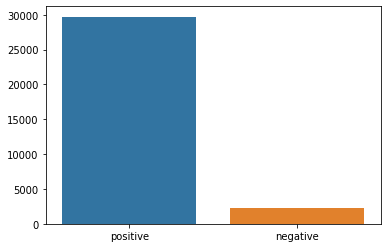

In [6]:
dd = train_df['label'].value_counts()
sns.barplot(x=np.array(['positive','negative']),y=dd.values)
plt.show()

In [8]:
X,y=train_df['tweet'].values,train_df['label'].values

X=X.reshape(-1,1)
y=y.reshape(-1,1)
ros=RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X, y)

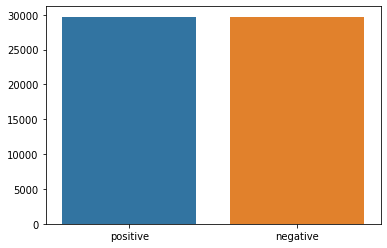

In [9]:
dd_1= pd.Series(y_resampled).value_counts()
sns.barplot(x=np.array(['positive','negative']),y=dd_1.values)
plt.show()


In [10]:
print(dd)
print(dd_1)

0    29720
1     2242
Name: label, dtype: int64
0    29720
1    29720
dtype: int64


In [11]:
train_df_new=pd.concat([pd.DataFrame(X_resampled),pd.DataFrame(y_resampled)],axis=1)

In [12]:
train_df_new.set_axis(['Tweets','values'],axis='columns',inplace=True)
print(train_df_new.columns)

Index(['Tweets', 'values'], dtype='object')


In [13]:
print(train_df_new)

                                                  Tweets  values
0       @user when a father is dysfunctional and is s...       0
1      @user @user thanks for #lyft credit i can't us...       0
2                                    bihday your majesty       0
3      #model   i love u take with u all the time in ...       0
4                 factsguide: society now    #motivation       0
...                                                  ...     ...
59435  not to sound  but @user has her looks to fall ...       1
59436  heard #ris2016 clip. see quoted tweet. props t...       1
59437  you'd think #blacklivesmatter would b protesti...       1
59438  are you #hispanic &amp; feel like the  are sto...       1
59439  @user yup. i concur. as do nearly 3 million vo...       1

[59440 rows x 2 columns]


In [15]:


X,y = train_df_new['Tweets'].values,train_df_new['values'].values
x_train,x_val,y_train,y_val = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_val.shape}')



shape of train data is (44580,)
shape of test data is (14860,)


In [19]:
from nltk.corpus import stopwords
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s
def remove_links_mentions(tweet):
    link_re_pattern = "https?:\/\/t.co/[\w]+"
    mention_re_pattern = "@\w+"
    tweet = re.sub(link_re_pattern, "", tweet)
    tweet = re.sub(mention_re_pattern, "", tweet)
    return tweet.lower()

def tockenize(x_train,x_val):
    word_list = []
    stop_words_english = stopwords.words('english')
    stop_words=set(stop_words_english)
    for sent in x_train:
        for word in sent.lower().split():
            word = remove_links_mentions(preprocess_string(word))
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    _dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in _dict.keys()])
    for sent in x_val:
            final_list_test.append([_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in _dict.keys()])
            
    return np.array(final_list_train),np.array(final_list_test),_dict

In [20]:
x_train,x_val,vocab = tockenize(x_train,x_val)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [21]:
print(f'Length of vocabulary is {len(vocab)}')


Length of vocabulary is 1000


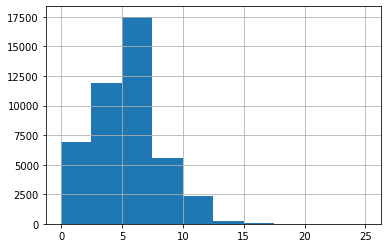

count    44580.000000
mean         5.198789
std          2.614610
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         25.000000
dtype: float64

In [22]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [23]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [24]:
x_train_pad = padding_(x_train,30)
x_val_pad = padding_(x_val,30)

In [25]:
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_val_pad), torch.from_numpy(y_val))

batch_size = 64


train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [99]:

criterion=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)